In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer  # For converting text data into TF-IDF vectors
from sklearn.metrics.pairwise import cosine_similarity  # For computing cosine similarity between vectors
from scipy.spatial.distance import pdist, squareform  # For pairwise distance computations and converting to a square matrix
import pickle
import math
import seaborn as sns
sns.set_style("whitegrid")

# pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [56]:
anime_df = pd.read_csv("anime_meta.csv")
rating_df = pd.read_csv("ratings.csv")

In [3]:
#---------- load ----------
with open("rating_df_final.pk", "rb") as f:
    rating_df = pickle.load(f)
with open("anime_df_final.pk", "rb") as f:
    anime_df = pickle.load(f)

Exploratory Data Analysis

In [4]:
anime_df.head()

,anime_name,anime_id,Genres,Score,Synopsis,Score_num
0,Fullmetal Alchemist: Brotherhood,5114,"Action, Military, Adventure, Comedy, Drama, Ma...",9.19,"""In order for something to be obtained, someth...",9.19
1,Shingeki no Kyojin: The Final Season,40028,"Action, Military, Mystery, Super Power, Drama,...",9.17,Gabi Braun and Falco Grice have been training ...,9.17
2,Steins;Gate,9253,"Thriller, Sci-Fi",9.11,The self-proclaimed mad scientist Rintarou Oka...,9.11
3,Hunter x Hunter (2011),11061,"Action, Adventure, Fantasy, Shounen, Super Power",9.1,Hunter x Hunter is set in a world where Hunter...,9.10
4,Shingeki no Kyojin Season 3 Part 2,38524,"Action, Drama, Fantasy, Military, Mystery, Sho...",9.1,Seeking to restore humanity's diminishing hope...,9.10


In [5]:
rating_df.head()

,user_id,anime_id,rating,anime_name
4511,36,6512,7,Nyan Koi!
4512,36,5958,7,Sora no Otoshimono
4513,36,6802,8,So Ra No Wo To
4514,36,17187,8,Koukaku Kidoutai Arise: Ghost in the Shell - B...
4515,36,16498,8,Shingeki no Kyojin


In [8]:
anime_df.shape

(3000, 6)

In [9]:
rating_df.shape

(1435890, 4)

In [10]:
anime_df['anime_name'].nunique()

3000

In [11]:
rating_df['user_id'].nunique()

10000

In [60]:
print("\nMissing values per column:")
print(rating_df.isna().mean().mul(100).round(1))


Missing values per column:
user_id       0.0
anime_id      0.0
rating        0.0
anime_name    0.0
dtype: float64


In [61]:
print("\nMissing values per column:")
print(anime_df.isna().mean().mul(100).round().round(1))


Missing values per column:
anime_name    0.0
anime_id      0.0
Genres        0.0
Score         0.0
Synopsis      0.0
dtype: float64


In [62]:
# 1) Count missing/"Unknown" values in anime_df
unk_name   = (anime_df['anime_name'] == 'Unknown').sum()
unk_score  = (anime_df['Score']       == 'Unknown').sum()
unk_genres = (anime_df['Genres']      == 'Unknown').sum()

print("anime_df: Unknown anime_name:",   unk_name)
print("anime_df: Unknown Score:",        unk_score)
print("anime_df: Unknown Genres:",       unk_genres)

# 2) Count missing/"Unknown" values in rating_df
unk_uid    = (rating_df['user_id'].astype(str) == 'Unknown').sum()
unk_aid    = (rating_df['anime_id'].astype(str) == 'Unknown').sum()
unk_rating = (rating_df['rating'].astype(str)   == 'Unknown').sum()

print("rating_df: Unknown user_id:",   unk_uid)
print("rating_df: Unknown anime_id:",  unk_aid)
print("rating_df: Unknown rating:",    unk_rating)

# 3) Drop those rows from anime_df
anime_df = anime_df[
    (anime_df['anime_name'] != 'Unknown') &
    (anime_df['Score']      != 'Unknown') &
    (anime_df['Genres']     != 'Unknown')
].reset_index(drop=True)

# 4) Drop those rows from rating_df
rating_df = rating_df[
    (rating_df['user_id'].astype(str)   != 'Unknown') &
    (rating_df['anime_id'].astype(str)  != 'Unknown') &
    (rating_df['rating'].astype(str)    != 'Unknown')
].reset_index(drop=True)

# 5) Verify that nothing remains
print("\nAfter dropping:")
print("anime_df_clean: Unknown anime_name:",   (anime_df['anime_name']=="Unknown").sum())
print("anime_df_clean: Unknown Score:",        (anime_df['Score']=="Unknown").sum())
print("anime_df_clean: Unknown Genres:",       (anime_df['Genres']=="Unknown").sum())

print("rating_df_clean: Unknown user_id:",   (rating_df['user_id'].astype(str)=="Unknown").sum())
print("rating_df_clean: Unknown anime_id:",  (rating_df['anime_id'].astype(str)=="Unknown").sum())
print("rating_df_clean: Unknown rating:",    (rating_df['rating'].astype(str)=="Unknown").sum())


anime_df: Unknown anime_name: 0
anime_df: Unknown Score: 3000
anime_df: Unknown Genres: 20
rating_df: Unknown user_id: 0
rating_df: Unknown anime_id: 0
rating_df: Unknown rating: 0

After dropping:
anime_df_clean: Unknown anime_name: 0
anime_df_clean: Unknown Score: 0
anime_df_clean: Unknown Genres: 0
rating_df_clean: Unknown user_id: 0
rating_df_clean: Unknown anime_id: 0


KeyboardInterrupt: 

In [ ]:
# Compute the true average Score per anime
avg_scores = (
    anime_df
      .groupby('anime_id')['Score']         
      .mean()                              
      .reset_index()
)
#Pull one representative row per anime_id (keep all other columns)
#drop duplicates based on anime_id, keeping the first
anime_meta = anime_df.drop_duplicates(subset='anime_id').copy()

# 3) Drop the old per-user Score from that
anime_meta = anime_meta.drop(columns=['Score'])

# 4) Merge the average scores back
anime_df = anime_meta.merge(avg_scores, on='anime_id', how='left')

# 5) Verify
print(anime_df.shape)          # should be (#distinct anime, #cols)
print(anime_df.dtypes)        # Score now float
print(anime_df.head())


(3000, 6)
anime_name     object
anime_id        int64
Genres         object
Synopsis       object
Score_num     float64
Score         float64
dtype: object
                             anime_name  anime_id  \
0      Fullmetal Alchemist: Brotherhood      5114   
1  Shingeki no Kyojin: The Final Season     40028   
2                           Steins;Gate      9253   
3                Hunter x Hunter (2011)     11061   
4    Shingeki no Kyojin Season 3 Part 2     38524   

                                              Genres  \
0  Action, Military, Adventure, Comedy, Drama, Ma...   
1  Action, Military, Mystery, Super Power, Drama,...   
2                                   Thriller, Sci-Fi   
3   Action, Adventure, Fantasy, Shounen, Super Power   
4  Action, Drama, Fantasy, Military, Mystery, Sho...   

                                            Synopsis  Score_num  Score  
0  "In order for something to be obtained, someth...       9.19   9.19  
1  Gabi Braun and Falco Grice have been tr

In [14]:
anime_df.size

18000

In [15]:
rating_df.size

5743560

In [16]:
rating_df['user_id'].nunique()

10000

Viewing Top 50 Ranked animes

In [17]:
Top_animes = anime_df.sort_values(by="Score", ascending=False)
# pull both columns, reset the index, and shift display index to start at 1
names_and_ratings = (
    Top_animes[['anime_name','Score']]
      .reset_index(drop=True)
)
names_and_ratings.index += 1


In [94]:
names_and_ratings.head(25)

,anime_name,Score
1,Fullmetal Alchemist: Brotherhood,9.19
2,Shingeki no Kyojin: The Final Season,9.17
3,Steins;Gate,9.11
4,Hunter x Hunter (2011),9.10
5,Shingeki no Kyojin Season 3 Part 2,9.10
6,Gintama°,9.10
7,Gintama',9.08
8,Ginga Eiyuu Densetsu,9.07
9,Gintama': Enchousen,9.04
10,Koe no Katachi,9.00


In [18]:
anime_df['Score'].max()

np.float64(9.19)

In [30]:
anime_df['Score'].min()

np.float64(7.16)

In [31]:
rating_df['rating'].max()

np.int64(10)

In [33]:
rating_df['rating'].min()

np.int64(1)

All Possible Genres

In [34]:
possible_genres = anime_df['Genres'].str.split(',').explode().str.strip().unique()
possible_genres

array(['Action', 'Military', 'Adventure', 'Comedy', 'Drama', 'Magic',
       'Fantasy', 'Shounen', 'Mystery', 'Super Power', 'Thriller',
       'Sci-Fi', 'Historical', 'Parody', 'Samurai', 'Space', 'School',
       'Game', 'Seinen', 'Slice of Life', 'Romance', 'Supernatural',
       'Vampire', 'Mecha', 'Sports', 'Josei', 'Horror', 'Police',
       'Psychological', 'Music', 'Martial Arts', 'Demons', 'Shoujo',
       'Dementia', 'Harem', 'Ecchi', 'Kids', 'Shounen Ai', 'Cars',
       'Shoujo Ai', 'Hentai', 'Yaoi', 'Yuri'], dtype=object)

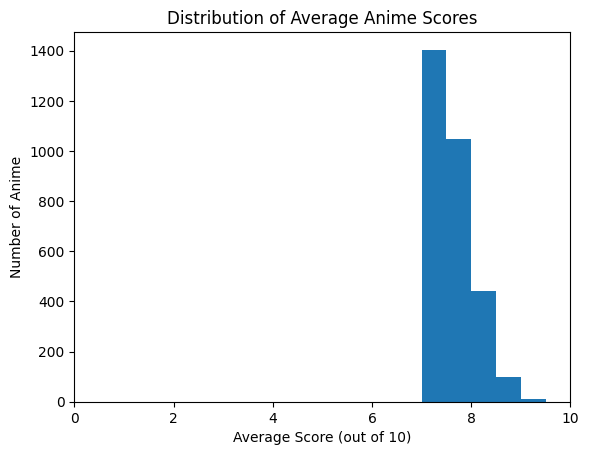

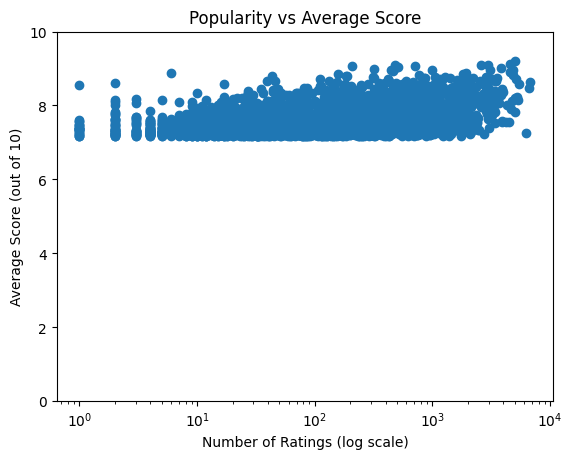

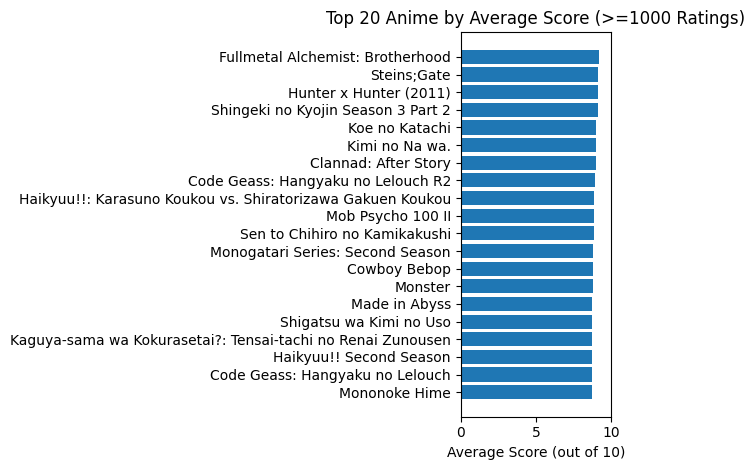

In [35]:
# 1) Build stats (avg_score + num_ratings + anime_name)
rating_counts = rating_df.groupby('anime_id')['user_id'] \
                         .count() \
                         .rename('num_ratings')
stats = pd.DataFrame({
    'avg_score': anime_df.set_index('anime_id')['Score'],
    'num_ratings': rating_counts
})
stats['anime_name'] = anime_df.set_index('anime_id')['anime_name']

# 2) Histogram of average scores (0–10)
plt.figure()
plt.hist(stats['avg_score'], bins=np.linspace(0, 10, 21), range=(0, 10))
plt.title('Distribution of Average Anime Scores')
plt.xlabel('Average Score (out of 10)')
plt.ylabel('Number of Anime')
plt.xlim(0, 10)
plt.show()

# 3) Scatter: popularity vs. average score
plt.figure()
plt.scatter(stats['num_ratings'], stats['avg_score'])
plt.xscale('log')
plt.title('Popularity vs Average Score')
plt.xlabel('Number of Ratings (log scale)')
plt.ylabel('Average Score (out of 10)')
plt.ylim(0, 10)
plt.show()

# 4) Top 20 anime by average score (min 1000 ratings)
top20 = stats[stats['num_ratings'] > 1000] \
            .sort_values('avg_score', ascending=False) \
            .head(20)
plt.figure()
plt.barh(top20['anime_name'][::-1], top20['avg_score'][::-1])
plt.title('Top 20 Anime by Average Score (>=1000 Ratings)')
plt.xlabel('Average Score (out of 10)')
plt.xlim(0, 10)
plt.tight_layout()
plt.show()


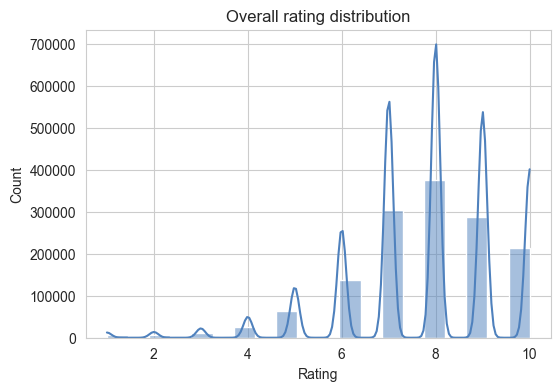

In [37]:
# ----------------------------------------------------------
# 2. RATING DISTRIBUTION  (how generous / harsh are users?)
# ----------------------------------------------------------
plt.figure(figsize=(6,4))
sns.histplot(rating_df["rating"], bins=20, kde=True, color="#4F81BD")
plt.title("Overall rating distribution")
plt.xlabel("Rating"); plt.ylabel("Count")
plt.show()

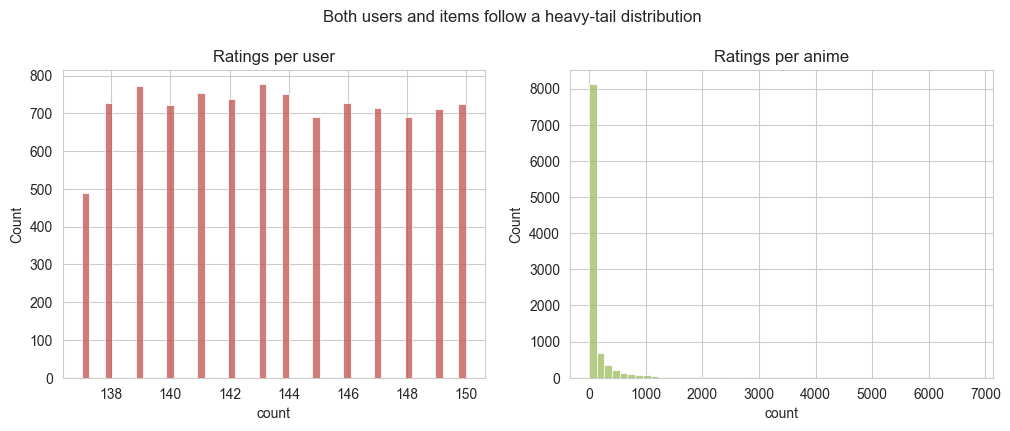

In [38]:
# ----------------------------------------------------------
# 3. USER-ACTIVITY & ITEM-POPULARITY  (long-tail check)
# ----------------------------------------------------------
user_counts  = rating_df.groupby("user_id").size()
item_counts  = rating_df.groupby("anime_id").size()

fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(user_counts, bins=50, ax=ax[0], color="#C0504D")
ax[0].set_title("Ratings per user");  ax[0].set_xlabel("count")
sns.histplot(item_counts, bins=50, ax=ax[1], color="#9BBB59")
ax[1].set_title("Ratings per anime"); ax[1].set_xlabel("count")
plt.suptitle("Both users and items follow a heavy-tail distribution", y=1.03)
plt.show()

In [39]:
# How many one-off users/items?
print("Users with <5 ratings :", (user_counts<5).sum())
print("Animes with <10 ratings:", (item_counts<10).sum())

Users with <5 ratings : 0
Animes with <10 ratings: 4408


C:\Users\Dell\AppData\Local\Temp\ipykernel_10216\380658863.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genres_exploded.values, y=genres_exploded.index, palette="Blues_r")


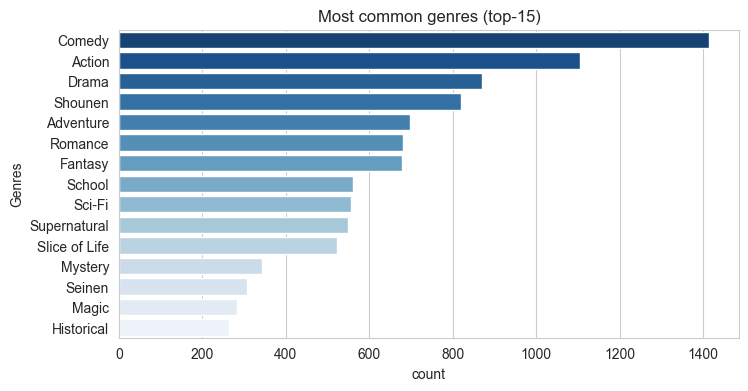

In [41]:
# ----------------------------------------------------------
# 4. GENRE BREAKDOWN (top-15)  – for diversity / bias talk
# ----------------------------------------------------------
genres_exploded = (
    anime_df["Genres"]
      .str.split(",")
      .explode()
      .str.strip()
      .value_counts()
      .head(15)
)
plt.figure(figsize=(8,4))
sns.barplot(x=genres_exploded.values, y=genres_exploded.index, palette="Blues_r")
plt.title("Most common genres (top-15)")
plt.xlabel("count")
plt.show()


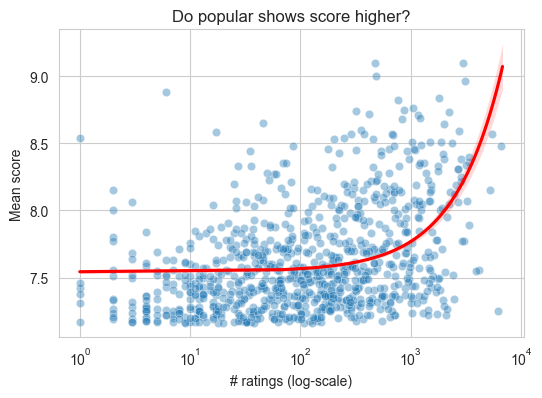

In [42]:
# ----------------------------------------------------------
# 5. CORRELATION BETWEEN ITEM SCORE AND POPULARITY
# ----------------------------------------------------------
anime_pop = item_counts.rename("num_ratings").to_frame().join(
    anime_df.set_index("anime_id")["Score_num"]
)

plt.figure(figsize=(6,4))
sns.scatterplot(data=anime_pop.sample(3000, random_state=0),
                x="num_ratings", y="Score_num", alpha=0.4)
sns.regplot(data=anime_pop, x="num_ratings", y="Score_num",
            scatter=False, color="red")
plt.xscale("log")
plt.title("Do popular shows score higher?")
plt.xlabel("# ratings (log-scale)"); plt.ylabel("Mean score")
plt.show()

In [43]:
# Short write-up: weak positive trend (ρ≈{:.2f})
print("Spearman ρ :", anime_pop["num_ratings"].corr(anime_pop["Score_num"],
                                                   method="spearman").round(2))

Spearman ρ : 0.41


In [45]:
n_users  = rating_df["user_id"].nunique()
n_items  = rating_df["anime_id"].nunique()
nnz      = len(rating_df)          # number of filled cells
density  = nnz / (n_users * n_items)

print("Users               :", n_users)
print("Items               :", n_items)
print("Observed ratings    :", nnz)
print("Matrix sparsity     : {:.4f}  ({:.2%} filled)".format(density, density))

Users               : 10000
Items               : 10015
Observed ratings    : 1435890
Matrix sparsity     : 0.0143  (1.43% filled)


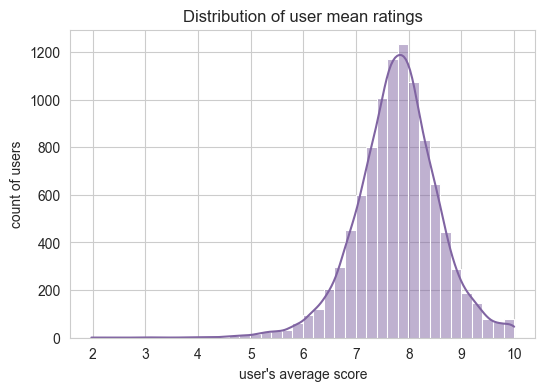

In [49]:
# compute *per-user* average rating
user_avg = rating_df.groupby("user_id")["rating"].mean()

plt.figure(figsize=(6,4))
sns.histplot(user_avg.values, bins=40, kde=True, color="#8064A2")
plt.title("Distribution of user mean ratings")
plt.xlabel("user's average score")
plt.ylabel("count of users")
plt.show()


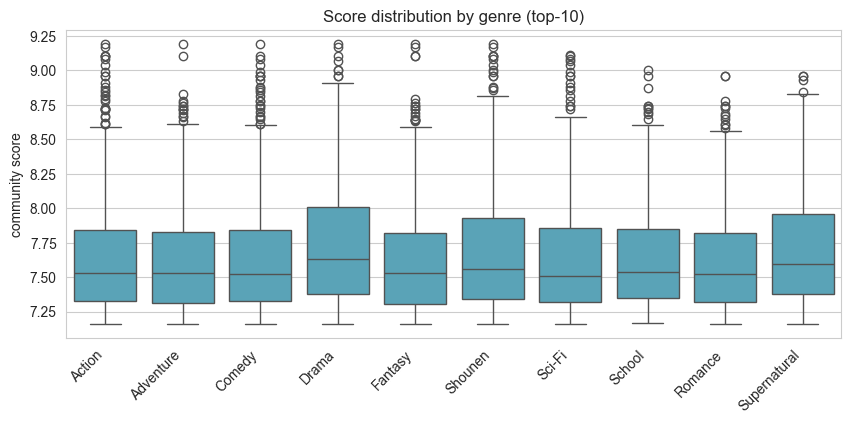

In [48]:
genre_scores = (
    anime_df[["anime_id", "Score_num", "Genres"]]
      .dropna(subset=["Score_num"])
      .assign(Genres=lambda d: d["Genres"].str.split(","))
      .explode("Genres")
      .assign(Genres=lambda d: d["Genres"].str.strip())
)

top10_genres = (
    genre_scores["Genres"]
      .value_counts()
      .head(10)
      .index
)

plt.figure(figsize=(10,4))
sns.boxplot(data=genre_scores.query("Genres in @top10_genres"),
            x="Genres", y="Score_num", color="#4BACC6")
plt.xticks(rotation=45, ha="right")
plt.title("Score distribution by genre (top-10)")
plt.xlabel(""); plt.ylabel("community score")
plt.show()
